<a href="https://colab.research.google.com/github/rkarpin/ML_LAB/blob/main/ML_homework_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch, random, math, numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
seed = 0
random.seed(seed); np.random.seed(seed)
torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.use_deterministic_algorithms(True)

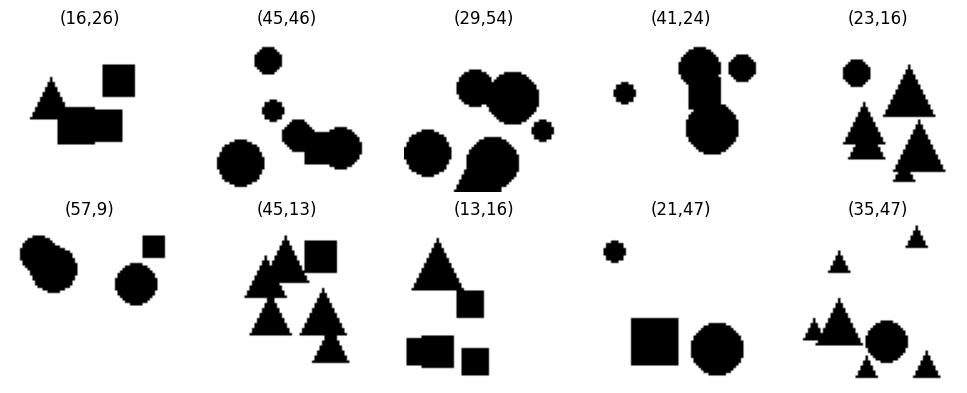

In [4]:
IMAGE = 64
SHAPES = ("circle", "square", "triangle")

def draw_shape(drawer, shape_type, center_x, center_y, radius):
    if shape_type == "circle":
        drawer.ellipse([center_x - radius, center_y - radius,
                        center_x + radius, center_y + radius], fill="black")
    elif shape_type == "square":
        drawer.rectangle([center_x - radius, center_y - radius,
                          center_x + radius, center_y + radius], fill="black")
    else:  # triangle
        drawer.polygon([
            (center_x, center_y - radius),
            (center_x - radius, center_y + radius),
            (center_x + radius, center_y + radius)
        ], fill="black")

class OddXYDataset(Dataset):
    """
    Generates images on-the-fly:
      * several random shapes of the same type
      * 1 additional shape of a different type
    Returns:
      * image (1×64×64 tensor, float32 normalized to [0,1])
      * label: float tensor [cx, cy] with center of the odd shape
    Arguments:
        num_samples             – total number of samples in the dataset
        same_shape_count_range – tuple (min, max), number of identical shapes
        shape_radius_range      – tuple (min_radius, max_radius) for shape size
    """
    def __init__(self,
                 num_samples,
                 same_shape_count_range=(3, 6),
                 shape_radius_range=(4, 10)):
        self.num_samples = num_samples
        self.same_shape_count_range = same_shape_count_range
        self.radius_min, self.radius_max = shape_radius_range

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        base_shape = random.choice(SHAPES)
        odd_shape = random.choice([s for s in SHAPES if s != base_shape])

        img = Image.new("L", (IMAGE, IMAGE), "white")
        drawer = ImageDraw.Draw(img)

        # draw identical shapes
        for _ in range(random.randint(*self.same_shape_count_range)):
            radius = random.randint(self.radius_min, self.radius_max)
            cx = random.randint(radius, IMAGE - radius - 1)
            cy = random.randint(radius, IMAGE - radius - 1)
            draw_shape(drawer, base_shape, cx, cy, radius)

        # draw the odd shape (with known center)
        radius = random.randint(self.radius_min, self.radius_max)
        cx = random.randint(radius, IMAGE - radius - 1)
        cy = random.randint(radius, IMAGE - radius - 1)
        draw_shape(drawer, odd_shape, cx, cy, radius)

        img_tensor = torch.tensor(np.array(img), dtype=torch.float32).unsqueeze(0) / 255.
        label_tensor = torch.tensor([float(cx), float(cy)], dtype=torch.float32)
        return img_tensor, label_tensor

def show_examples(num_examples=10):
    """
    Displays a grid of image samples from OddXYDataset using a DataLoader with batch_size=1.

    Args:
        num_examples (int): Number of examples to display.
    """
    dataset = OddXYDataset(num_samples=num_examples)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    num_columns = 5
    num_rows = math.ceil(num_examples / num_columns)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 2, num_rows * 2))

    for i, (image, label) in enumerate(dataloader):
        if i >= num_examples:
            break
        image_np = image.squeeze(0).squeeze(0).numpy()  # B=1,C=1,H,W --> H,W
        cx, cy = label.squeeze(0)                       # B=1,2       --> 2
        axes.flat[i].imshow(image_np, cmap="gray")
        axes.flat[i].set_title(f"({cx:.0f},{cy:.0f})")
        axes.flat[i].axis("off")

    for j in range(i + 1, num_rows * num_columns):
        axes.flat[j].axis("off")

    plt.tight_layout()
    plt.show()



show_examples()

In [5]:
class Model(nn.Module):
  def __init__(self):

    super().__init__()

    # Embedding
    self.conv = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 20, stride = 4, padding = 0)

    # Positional Encoding
    pe = torch.zeros(144, 16)                                                                   # [144,16]
    pos = torch.arange(144, dtype=torch.float).unsqueeze(1)                                     # [144,1]
    div_term = torch.exp(torch.arange(0, 16, 2, dtype=torch.float)* (-math.log(10000.0) / 16))  # [8]
    pe[:, 0::2] = torch.sin(pos * div_term)
    pe[:, 1::2] = torch.cos(pos * div_term)
    self.register_buffer('pos_enc', pe)

    # Attention
    self.q_proj = nn.Linear(16, 16, bias=False)
    self.k_proj = nn.Linear(16, 16, bias=False)
    self.v_proj = nn.Linear(16, 16, bias=False)
    self.out_proj = nn.Linear(16, 16, bias=False)

    # Post-Processing
    self.classifier = nn.Sequential(nn.Linear(16, 16), nn.ReLU(inplace=True), nn.Linear(16, 1))


  def forward(self, x: torch.Tensor):

      B = x.size(0)

      # Embedding
      feat = self.conv(x)   # [B,16,12,12]

      # Positional Encoding
      tokens = feat.view(B, 16, 144).permute(0, 2, 1) + self.pos_enc.unsqueeze(0)    # [B,144,16]

      # Attention
      Q = self.q_proj(tokens)   # [B,144,16]
      K = self.k_proj(tokens)   # [B,144,16]
      V = self.v_proj(tokens)   # [B,144,16]

      scores = Q @ K.transpose(-2,-1) / 4         # [B,144,144]
      attention = torch.softmax(scores, dim=-1)   # [B,144,144]

      context = attention @ V               # [B,144,16]
      attended = self.out_proj(context)     # [B,144,16]

      # Post-Procesing
      logits = self.classifier(attended).squeeze(-1) # [B,144]
      probs = torch.softmax(logits, dim=1)           # [B,144]

      # Final Prediction
      centers = torch.arange(12).to(device) * 4 + 10                                 # [12]
      xs, ys = torch.meshgrid(centers, centers, indexing='xy')            # [12,12], [12,12]
      expected_x = (probs * xs.reshape(-1).unsqueeze(0)).sum(dim=1)       # [B]
      expected_y = (probs * ys.reshape(-1).unsqueeze(0)).sum(dim=1)       # [B]
      out = torch.stack([expected_x, expected_y], dim=1)                  # [B,2]

      return out, attention



# Training

def train(model, optimizer, device, num_epochs):

  model.to(device)
  mse_loss = nn.MSELoss()
  seed = 0


  def seed_worker(worker_id):
      worker_seed = seed + epoch + worker_id
      random.seed(worker_seed)
      np.random.seed(worker_seed)
      torch.manual_seed(worker_seed)
      if device.type == 'cuda':
          torch.cuda.manual_seed_all(worker_seed)


  g = torch.Generator()
  g.manual_seed(seed)

  rmse_history=[]

  for epoch in range(1, num_epochs + 1):

    epoch_seed = seed + epoch
    random.seed(epoch_seed)
    np.random.seed(epoch_seed)
    torch.manual_seed(epoch_seed)
    if device.type == 'cuda':
        torch.cuda.manual_seed_all(epoch_seed)

    dataset = OddXYDataset(num_samples=25000)

    dataloader = DataLoader(dataset, batch_size=25, shuffle=True, num_workers=2, worker_init_fn=seed_worker, generator=g)

    model.train()
    squared_errors = 0
    for images, labels in dataloader:
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs, attention = model(images)
      loss = mse_loss(outputs, labels)
      loss.backward()
      optimizer.step()
      squared_errors += loss.item() * images.size(0)

    rmse = math.sqrt(squared_errors / len(dataloader.dataset))
    rmse_history.append(rmse)
    print(f"Epoch {epoch}/{num_epochs}, RMSE: {rmse:.4f}")

  return rmse_history, attention






In [6]:
model = Model()
optimizer = optim.Adam(model.parameters(), lr=0.001)
rmse_history, attention = train(model, optimizer, device, num_epochs=25)

torch.save(model.state_dict(), 'model_parameters.pth')

Epoch 1/25, RMSE: 13.5416
Epoch 2/25, RMSE: 13.1570
Epoch 3/25, RMSE: 12.3968
Epoch 4/25, RMSE: 11.7169
Epoch 5/25, RMSE: 11.2692
Epoch 6/25, RMSE: 11.0189
Epoch 7/25, RMSE: 10.7370
Epoch 8/25, RMSE: 10.5242
Epoch 9/25, RMSE: 10.3653
Epoch 10/25, RMSE: 10.3067
Epoch 11/25, RMSE: 10.1517
Epoch 12/25, RMSE: 10.0687
Epoch 13/25, RMSE: 10.0436
Epoch 14/25, RMSE: 9.8673
Epoch 15/25, RMSE: 9.7204
Epoch 16/25, RMSE: 9.7248
Epoch 17/25, RMSE: 9.8089
Epoch 18/25, RMSE: 9.7359
Epoch 19/25, RMSE: 9.6231
Epoch 20/25, RMSE: 9.5092
Epoch 21/25, RMSE: 9.5635
Epoch 22/25, RMSE: 9.6626
Epoch 23/25, RMSE: 9.5554
Epoch 24/25, RMSE: 9.3999
Epoch 25/25, RMSE: 9.4056


In [7]:
model1=Model()
model1.load_state_dict(torch.load('model_parameters.pth'))
optimizer1 = optim.Adam(model1.parameters(), lr=0.0001)
rmse_history1, attention = train(model1, optimizer1, device, num_epochs=25)

torch.save(model1.state_dict(), 'model_parameters1.pth')


Epoch 1/25, RMSE: 9.0212
Epoch 2/25, RMSE: 8.9722
Epoch 3/25, RMSE: 8.9832
Epoch 4/25, RMSE: 8.8459
Epoch 5/25, RMSE: 8.8179
Epoch 6/25, RMSE: 8.8459
Epoch 7/25, RMSE: 8.8110
Epoch 8/25, RMSE: 8.7465
Epoch 9/25, RMSE: 8.7359
Epoch 10/25, RMSE: 8.7591
Epoch 11/25, RMSE: 8.6720
Epoch 12/25, RMSE: 8.6470
Epoch 13/25, RMSE: 8.6478
Epoch 14/25, RMSE: 8.5816
Epoch 15/25, RMSE: 8.6022
Epoch 16/25, RMSE: 8.6081
Epoch 17/25, RMSE: 8.6251
Epoch 18/25, RMSE: 8.6470
Epoch 19/25, RMSE: 8.5845
Epoch 20/25, RMSE: 8.5437
Epoch 21/25, RMSE: 8.6688
Epoch 22/25, RMSE: 8.7242
Epoch 23/25, RMSE: 8.5945
Epoch 24/25, RMSE: 8.5164
Epoch 25/25, RMSE: 8.5895


In [8]:
model2=Model()
model2.load_state_dict(torch.load('model_parameters1.pth'))
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)
rmse_history2, attention = train(model2, optimizer2, device, num_epochs=200)

torch.save(model2.state_dict(), 'model_parameters2.pth')


Epoch 1/200, RMSE: 8.7167
Epoch 2/200, RMSE: 8.7138
Epoch 3/200, RMSE: 8.7643
Epoch 4/200, RMSE: 8.6535
Epoch 5/200, RMSE: 8.6011
Epoch 6/200, RMSE: 8.6395
Epoch 7/200, RMSE: 8.6190
Epoch 8/200, RMSE: 8.5654
Epoch 9/200, RMSE: 8.5498
Epoch 10/200, RMSE: 8.5709
Epoch 11/200, RMSE: 8.4949
Epoch 12/200, RMSE: 8.4895
Epoch 13/200, RMSE: 8.4848
Epoch 14/200, RMSE: 8.4242
Epoch 15/200, RMSE: 8.4373
Epoch 16/200, RMSE: 8.4395
Epoch 17/200, RMSE: 8.4870
Epoch 18/200, RMSE: 8.5080
Epoch 19/200, RMSE: 8.4298
Epoch 20/200, RMSE: 8.3771
Epoch 21/200, RMSE: 8.5190
Epoch 22/200, RMSE: 8.5774
Epoch 23/200, RMSE: 8.4599
Epoch 24/200, RMSE: 8.4128
Epoch 25/200, RMSE: 8.4969
Epoch 26/200, RMSE: 8.5923
Epoch 27/200, RMSE: 8.6034
Epoch 28/200, RMSE: 8.5526
Epoch 29/200, RMSE: 8.5764
Epoch 30/200, RMSE: 8.5991
Epoch 31/200, RMSE: 8.6908
Epoch 32/200, RMSE: 8.6367
Epoch 33/200, RMSE: 8.4162
Epoch 34/200, RMSE: 8.4015
Epoch 35/200, RMSE: 8.5369
Epoch 36/200, RMSE: 8.5518
Epoch 37/200, RMSE: 8.4530
Epoch 38/2

In [13]:
model3=Model()
model3.load_state_dict(torch.load('model_parameters2.pth'))
optimizer3 = optim.Adam(model3.parameters(), lr=0.0001)
rmse_history3, attention = train(model3, optimizer3, device, num_epochs=200)

torch.save(model3.state_dict(), 'model_parameters3.pth')


Epoch 1/200, RMSE: 8.0220
Epoch 2/200, RMSE: 8.1124
Epoch 3/200, RMSE: 8.1917
Epoch 4/200, RMSE: 8.0766
Epoch 5/200, RMSE: 8.0209
Epoch 6/200, RMSE: 8.0323
Epoch 7/200, RMSE: 8.0006
Epoch 8/200, RMSE: 7.9661
Epoch 9/200, RMSE: 7.8933
Epoch 10/200, RMSE: 7.9037
Epoch 11/200, RMSE: 7.9749
Epoch 12/200, RMSE: 7.9687
Epoch 13/200, RMSE: 7.9626
Epoch 14/200, RMSE: 7.9324
Epoch 15/200, RMSE: 7.9035
Epoch 16/200, RMSE: 7.9132
Epoch 17/200, RMSE: 7.9448
Epoch 18/200, RMSE: 7.9773
Epoch 19/200, RMSE: 7.9370
Epoch 20/200, RMSE: 7.8609
Epoch 21/200, RMSE: 7.9678
Epoch 22/200, RMSE: 8.0365
Epoch 23/200, RMSE: 7.9912
Epoch 24/200, RMSE: 7.9464
Epoch 25/200, RMSE: 8.0199
Epoch 26/200, RMSE: 8.0671
Epoch 27/200, RMSE: 8.0452
Epoch 28/200, RMSE: 8.0340
Epoch 29/200, RMSE: 8.0561
Epoch 30/200, RMSE: 8.0229
Epoch 31/200, RMSE: 8.0887
Epoch 32/200, RMSE: 8.0953
Epoch 33/200, RMSE: 7.8639
Epoch 34/200, RMSE: 7.8371
Epoch 35/200, RMSE: 8.0082
Epoch 36/200, RMSE: 7.9498
Epoch 37/200, RMSE: 7.8349
Epoch 38/2

In [20]:
model4=Model()
model4.load_state_dict(torch.load('model_parameters3.pth'))
optimizer4 = optim.Adam(model4.parameters(), lr=0.001)
rmse_history4, attention = train(model4, optimizer4, device, num_epochs=200)

torch.save(model4.state_dict(), 'model_parameters4.pth')


Epoch 1/200, RMSE: 8.7441
Epoch 2/200, RMSE: 8.6886
Epoch 3/200, RMSE: 8.7127
Epoch 4/200, RMSE: 8.6722
Epoch 5/200, RMSE: 8.5276
Epoch 6/200, RMSE: 8.5682
Epoch 7/200, RMSE: 8.6451
Epoch 8/200, RMSE: 8.5443
Epoch 9/200, RMSE: 8.4332
Epoch 10/200, RMSE: 8.3791
Epoch 11/200, RMSE: 8.5730
Epoch 12/200, RMSE: 8.6060
Epoch 13/200, RMSE: 8.4771
Epoch 14/200, RMSE: 8.3992
Epoch 15/200, RMSE: 8.4401
Epoch 16/200, RMSE: 8.3808
Epoch 17/200, RMSE: 8.4564
Epoch 18/200, RMSE: 8.3696
Epoch 19/200, RMSE: 8.4618
Epoch 20/200, RMSE: 8.3546
Epoch 21/200, RMSE: 8.3401
Epoch 22/200, RMSE: 8.5011
Epoch 23/200, RMSE: 8.4552
Epoch 24/200, RMSE: 8.4273
Epoch 25/200, RMSE: 8.4209
Epoch 26/200, RMSE: 8.4464
Epoch 27/200, RMSE: 8.4667
Epoch 28/200, RMSE: 8.4527
Epoch 29/200, RMSE: 8.4162
Epoch 30/200, RMSE: 8.4049
Epoch 31/200, RMSE: 8.4730
Epoch 32/200, RMSE: 8.5340
Epoch 33/200, RMSE: 8.3827
Epoch 34/200, RMSE: 8.2190
Epoch 35/200, RMSE: 8.3627
Epoch 36/200, RMSE: 8.3100
Epoch 37/200, RMSE: 8.1477
Epoch 38/2

In [21]:
model5=Model()
model5.load_state_dict(torch.load('model_parameters4.pth'))
optimizer5 = optim.Adam(model5.parameters(), lr=0.001)
rmse_history5, attention = train(model5, optimizer5, device, num_epochs=200)

torch.save(model5.state_dict(), 'model_parameters5.pth')


Epoch 1/200, RMSE: 7.8485
Epoch 2/200, RMSE: 7.9020
Epoch 3/200, RMSE: 7.9036
Epoch 4/200, RMSE: 7.8584
Epoch 5/200, RMSE: 7.7898
Epoch 6/200, RMSE: 7.8902
Epoch 7/200, RMSE: 7.8226
Epoch 8/200, RMSE: 7.8009
Epoch 9/200, RMSE: 7.7470
Epoch 10/200, RMSE: 7.7500
Epoch 11/200, RMSE: 7.8109
Epoch 12/200, RMSE: 7.8466
Epoch 13/200, RMSE: 7.8569
Epoch 14/200, RMSE: 7.7787
Epoch 15/200, RMSE: 7.7729
Epoch 16/200, RMSE: 7.8037
Epoch 17/200, RMSE: 7.8113
Epoch 18/200, RMSE: 7.7482
Epoch 19/200, RMSE: 7.7679
Epoch 20/200, RMSE: 7.8076
Epoch 21/200, RMSE: 7.7567
Epoch 22/200, RMSE: 7.8037
Epoch 23/200, RMSE: 7.9023
Epoch 24/200, RMSE: 7.8462
Epoch 25/200, RMSE: 7.7386
Epoch 26/200, RMSE: 7.8205
Epoch 27/200, RMSE: 7.9495
Epoch 28/200, RMSE: 7.8863
Epoch 29/200, RMSE: 7.8613
Epoch 30/200, RMSE: 7.7922
Epoch 31/200, RMSE: 7.8525
Epoch 32/200, RMSE: 7.9167
Epoch 33/200, RMSE: 7.7606
Epoch 34/200, RMSE: 7.6980
Epoch 35/200, RMSE: 7.7633
Epoch 36/200, RMSE: 7.7600
Epoch 37/200, RMSE: 7.6585
Epoch 38/2

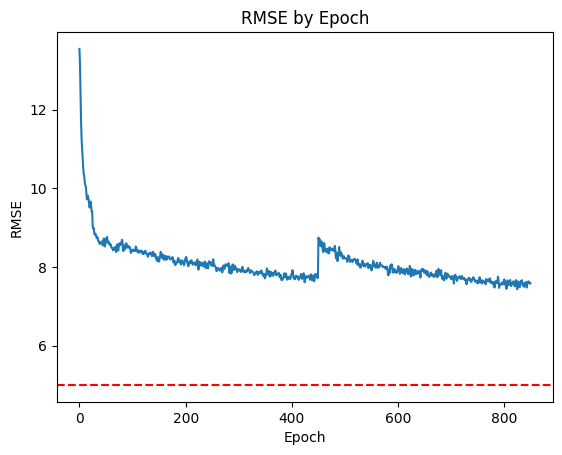

In [22]:
plt.plot(rmse_history+rmse_history1+rmse_history2+rmse_history3+rmse_history4+rmse_history5)
plt.title("RMSE by Epoch")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axhline(y=5, color='r', linestyle='--')
plt.show()

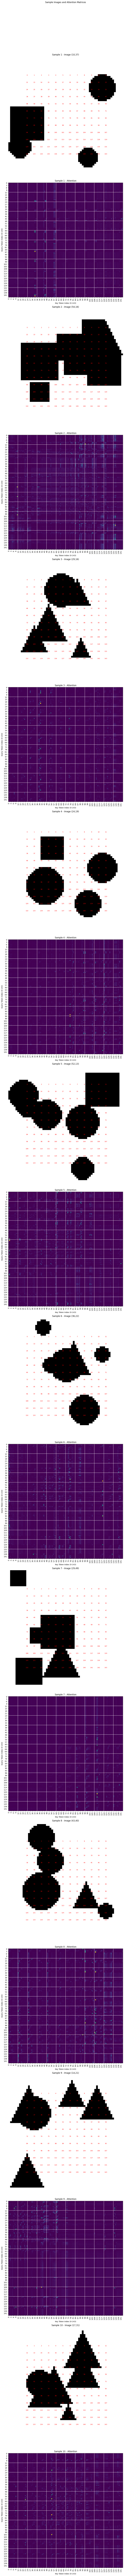

In [23]:
num_examples_to_show = 10

dataset = OddXYDataset(num_samples=num_examples_to_show)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

model.eval()


num_rows = num_examples_to_show * 2
num_cols = 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, num_rows * 10))
axes = axes.flatten()


with torch.no_grad():
    for i, (sample_image, sample_label) in enumerate(dataloader):
        if i >= num_examples_to_show:
            break

        sample_image = sample_image.to(device)

        output, attention = model(sample_image)


        centers = torch.arange(12).to(device) * 4 + 10
        xs, ys = torch.meshgrid(centers, centers, indexing='xy')
        grid_x = xs.reshape(-1).cpu().numpy()
        grid_y = ys.reshape(-1).cpu().numpy()

        attention_matrix = attention.squeeze(0).cpu().numpy()
        sample_image_np = sample_image.squeeze().cpu().numpy()


        img_ax_idx = i * 2
        att_ax_idx = i * 2 + 1


        axes[img_ax_idx].imshow(sample_image_np, cmap='gray')
        axes[img_ax_idx].set_title(f"Sample {i+1} - Image ({sample_label.squeeze().tolist()[0]:.0f},{sample_label.squeeze().tolist()[1]:.0f})")
        axes[img_ax_idx].axis('off')


        for j in range(144):
            axes[img_ax_idx].text(grid_x[j], grid_y[j], str(j), color='red', fontsize=8, ha='center', va='center')


        im = axes[att_ax_idx].imshow(attention_matrix, cmap='viridis', interpolation='nearest')
        axes[att_ax_idx].set_title(f"Sample {i+1} - Attention")
        axes[att_ax_idx].set_xlabel("Key Token Index (0-143)")
        axes[att_ax_idx].set_ylabel("Query Token Index (0-143)")


        tick_interval = 3
        max_tick = 144
        axes[att_ax_idx].set_xticks(np.arange(0, max_tick, tick_interval))
        axes[att_ax_idx].set_yticks(np.arange(0, max_tick, tick_interval))
        axes[att_ax_idx].set_xticklabels(np.arange(0, max_tick, tick_interval), rotation='vertical')
        axes[att_ax_idx].set_yticklabels(np.arange(0, max_tick, tick_interval))


        grid_interval = 12
        for g in np.arange(0, max_tick, grid_interval):
            axes[att_ax_idx].axvline(g - 0.5, color='white', linestyle='-', linewidth=1)
            axes[att_ax_idx].axhline(g - 0.5, color='white', linestyle='-', linewidth=1)


        axes[att_ax_idx].set_xlim([-0.5, max_tick - 0.5])
        axes[att_ax_idx].set_ylim([max_tick - 0.5, -0.5])


plt.tight_layout(h_pad=1.0)
plt.suptitle("Sample Images and Attention Matrices", y=1.02)
plt.show()

# Opis rozwiązania

Na wejściu model dostaje batch czarno białych obrazów 1x64x64. Obrazki przetwarzane są najpierw przez warstwę konwolucyjną, która wykorzystuje 16 jąder 20x20 (stride 4). Dzieli to obrazek na 144 nakładające się pola widzenia. Zatem ta warstwa daje nam embedding 144 tokenów w 16 wymiarowej przestrzeni. Do embeddingów dodajemy sinusoidalne kodowanie pozycji. Następnie otrzymane tokeny przekształcamy za pomocą samoatencji. Każdy token przepuszczmy przez 2-warstwową sieć MLP (warstwy mają po 16 neuronów) otrzymując w ten sposób łącznie 144 logity. Logity przepuszczamy przez softmax, dzięki czemu otrzymujemy rozkład prawdopodobieństwa, następnie liczymy z niego oczekiwane położnie szukanego punktu.

# Diagramy atencji

Na diagramach widzimy, że jasne punkty (te o największej wartości) odpowiadają obszarom znajdującym się przy krawędziach kształtów.